# TDoA (Time Difference of Arrival) localization

In [2]:
import pathlib
import numpy as np
import pandas as pd
import scipy
import scipy.io
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt

## Visualizing all the recievers on a plot

In [9]:
measurement_path = pathlib.Path('dataset/T20230222_1337_PoC_RDs_DMRS_UDP_Serial_Array_332_346_353_354_364_419_120.mat')
recievers = pd.read_csv(pathlib.Path('dataset/dot_coordinates.csv'), index_col='id_short')

In [10]:
recievers

,id_long,label,x,y,z
id_short,,,,,
120,TD3W211120,DOT20,25.082908,-9.11154,4.796871
126,TD3W211126,DOT21,42.465674,-17.51020,3.592475
131,TD3W211131,DOT22,39.125749,-37.54210,3.495790
133,TD3W211133,DOT23,32.514523,-29.61950,3.519441
153,TD3W211153,DOT24,10.790700,-42.59800,2.628408
323,TD3W201323,DOT01,43.170114,-8.38082,3.513311
332,TD3W201332,DOT02,24.468584,-21.65040,4.785801
338,TD3W201338,DOT04,32.171942,-21.73400,2.605779
346,TD3W201346,DOT05,8.460898,-18.29430,4.241591


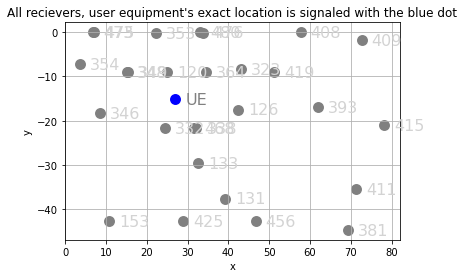

In [11]:
cmap = matplotlib.colormaps['Spectral']
fig, ax = plt.subplots()

recievers.plot('x', 'y', kind='scatter', ax=ax, s=120, linewidth=0, 
        c= 'gray')


ue_data = pd.read_csv('dataset/configuration.csv')


ue_data.plot('x', 'y', kind='scatter', ax=ax, s=120, linewidth=0, 
        c='blue')


for k, v in ue_data.iterrows():
    ax.annotate("UE", v[['x', 'y']],
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=16, color='grey')

for k, v in recievers.iterrows():
    ax.annotate(k, v[['x', 'y']],
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=16, color='lightgrey')
    
plt.title("All recievers, user equipment's exact location is signaled with the blue dot")

ax.grid(True)

In [12]:
recievers

,id_long,label,x,y,z
id_short,,,,,
120,TD3W211120,DOT20,25.082908,-9.11154,4.796871
126,TD3W211126,DOT21,42.465674,-17.51020,3.592475
131,TD3W211131,DOT22,39.125749,-37.54210,3.495790
133,TD3W211133,DOT23,32.514523,-29.61950,3.519441
153,TD3W211153,DOT24,10.790700,-42.59800,2.628408
323,TD3W201323,DOT01,43.170114,-8.38082,3.513311
332,TD3W201332,DOT02,24.468584,-21.65040,4.785801
338,TD3W201338,DOT04,32.171942,-21.73400,2.605779
346,TD3W201346,DOT05,8.460898,-18.29430,4.241591


## Visualizing the active recievers on a plot

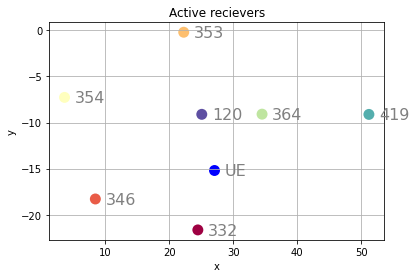

In [13]:
cmap = matplotlib.colormaps['Spectral']
fig, ax = plt.subplots()

ue_data.plot('x', 'y', kind='scatter', ax=ax, s=120, linewidth=0, 
        c='blue', colormap=cmap)

active_dots = [int(x) for x in measurement_path.stem.split('_')[-7:]]
df = recievers.loc[active_dots]
df.plot('x', 'y', kind='scatter', ax=ax, s=120, linewidth=0, 
        c=range(len(df)), colormap=cmap)

for k, v in ue_data.iterrows():
    ax.annotate("UE", v[['x', 'y']],
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=16, color='grey')

for k, v in df.iterrows():
    ax.annotate(k, v[['x', 'y']],
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=16, color='grey')
    
plt.title("Active recievers")
    
ax.grid(True)

### Data without any filtering

In [14]:
measurement_data = scipy.io.loadmat(measurement_path)

data = pd.DataFrame(measurement_data['UDP_data'][0])
data

c:\Users\pmaty\anaconda3\lib\site-packages\scipy\io\matlab\mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,msgType,seqNum,uepProcChain,ueProcChain,dpePortSel,dpeBrSel,modeRibmUtdoa,uepRefSel,refFftDelay,ueMaskStopIdx,ueMaskStartIdx,detectedOffset,delay_in_samples,Kmaxm1,KMmaxm1,RxyT,uePwrAccum
0,[[0]],[[15386]],[[0]],[[0]],[[0]],[[0]],[[0]],[[255]],[[0]],[[0]],[[0]],[00000000],[[0]],[[50]],[[0]],"[[(157-139j), (-40+134j), (-96-139j), (142+44j...",[[10]]
1,[[0]],[[15387]],[[0]],[[0]],[[0]],[[1]],[[0]],[[255]],[[0]],[[0]],[[0]],[00000000],[[0]],[[50]],[[0]],"[[(77+32j), (-4-129j), (-57+152j), (123-138j),...",[[9]]
2,[[0]],[[15388]],[[0]],[[0]],[[0]],[[2]],[[0]],[[255]],[[0]],[[0]],[[0]],[00000000],[[0]],[[50]],[[0]],"[[(150+119j), (38-49j), (-272+20j), (334+9j), ...",[[10]]
3,[[0]],[[15389]],[[0]],[[0]],[[0]],[[3]],[[0]],[[255]],[[0]],[[0]],[[0]],[00000000],[[0]],[[56]],[[0]],"[[(-26-63j), (-83+194j), (203-191j), (-233+17j...",[[10]]
4,[[0]],[[15390]],[[0]],[[0]],[[1]],[[0]],[[0]],[[255]],[[0]],[[0]],[[0]],[00000000],[[0]],[[62]],[[0]],"[[(12-123j), (-48+25j), (68+71j), (52-103j), (...",[[11]]
5,[[0]],[[15391]],[[0]],[[0]],[[1]],[[1]],[[0]],[[255]],[[0]],[[0]],[[0]],[00000000],[[0]],[[67]],[[0]],"[[(80+165j), (-71-172j), (7+59j), (61+75j), (-...",[[10]]
6,[[0]],[[15392]],[[0]],[[0]],[[1]],[[2]],[[0]],[[255]],[[0]],[[0]],[[0]],[00000000],[[0]],[[62]],[[0]],"[[(34+36j), (128-216j), (-68+104j), (-57-50j),...",[[11]]
7,[[0]],[[15393]],[[0]],[[0]],[[1]],[[3]],[[0]],[[255]],[[0]],[[0]],[[0]],[00000000],[[0]],[[72]],[[0]],"[[(30+17j), (2-172j), (-25+241j), (43-251j), (...",[[10]]
8,[[0]],[[15394]],[[0]],[[0]],[[2]],[[0]],[[0]],[[255]],[[0]],[[0]],[[0]],[00000000],[[0]],[[54]],[[0]],"[[(136-62j), (-37+178j), (-157-184j), (181+170...",[[10]]
9,[[0]],[[15395]],[[0]],[[0]],[[2]],[[1]],[[0]],[[255]],[[0]],[[0]],[[0]],[00000000],[[0]],[[55]],[[0]],"[[(63+19j), (-51+13j), (-2-55j), (91+22j), (-1...",[[10]]


### Filtered data

In [15]:
data = pd.DataFrame(measurement_data['UDP_data'][0]).applymap(
                                    lambda x: x[0][0] if len(x[0]) == 1 else x[0])[[
                                        'dpePortSel', 'dpeBrSel', 'RxyT', 'Kmaxm1'
                                    ]].drop_duplicates(subset=['dpePortSel', 'dpeBrSel'], keep='first')

data


,dpePortSel,dpeBrSel,RxyT,Kmaxm1
0,0,0,"[(157-139j), (-40+134j), (-96-139j), (142+44j)...",50
1,0,1,"[(77+32j), (-4-129j), (-57+152j), (123-138j), ...",50
2,0,2,"[(150+119j), (38-49j), (-272+20j), (334+9j), (...",50
3,0,3,"[(-26-63j), (-83+194j), (203-191j), (-233+17j)...",56
4,1,0,"[(12-123j), (-48+25j), (68+71j), (52-103j), (1...",62
5,1,1,"[(80+165j), (-71-172j), (7+59j), (61+75j), (-1...",67
6,1,2,"[(34+36j), (128-216j), (-68+104j), (-57-50j), ...",62
7,1,3,"[(30+17j), (2-172j), (-25+241j), (43-251j), (-...",72
8,2,0,"[(136-62j), (-37+178j), (-157-184j), (181+170j...",54
9,2,1,"[(63+19j), (-51+13j), (-2-55j), (91+22j), (-10...",55


### Visualizing the signal strength, with the strongest signal marked

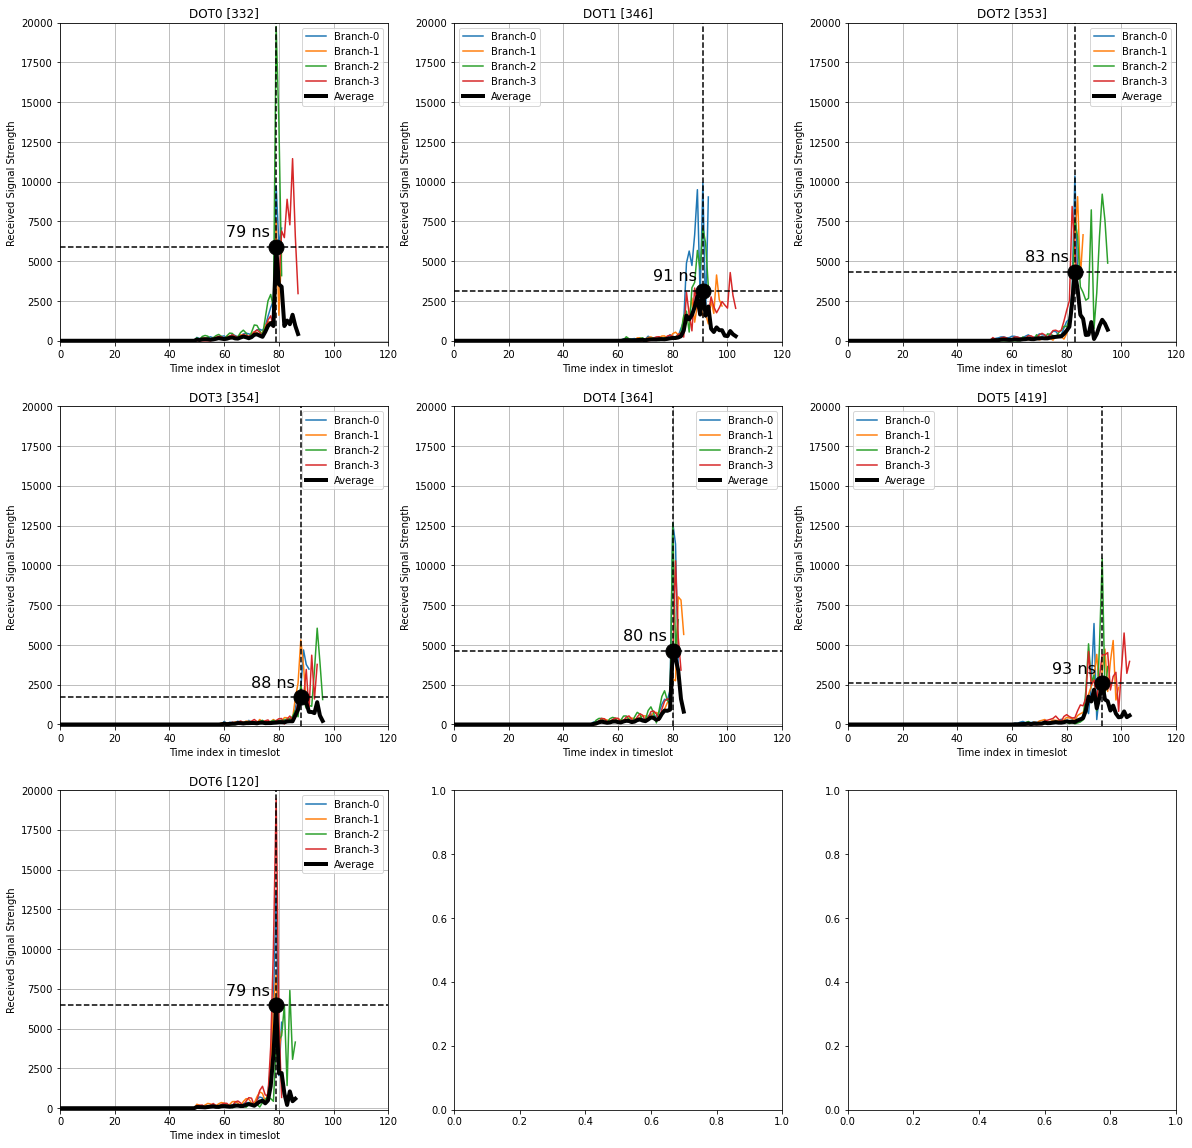

In [27]:

row_num, col_num = 3, 3
fig, ax = plt.subplots(figsize=(20, 20), nrows=row_num, ncols=col_num)
peaks = []
for ax_num in range(row_num*col_num):
    if(ax_num > 6):
        break
    average = []
    for _, measurement in data.query("dpePortSel == @ax_num").iterrows():
        record = np.concatenate((np.zeros(measurement['Kmaxm1']), np.abs(measurement['RxyT'])))
        ax[ax_num//col_num, ax_num%col_num].plot(record, label=f"Branch-{measurement['dpeBrSel']}", )
        ax[ax_num//col_num, ax_num%col_num].set_xlim([0,120])
        ax[ax_num//col_num, ax_num%col_num].set_ylim([-100,20000])
        ax[ax_num//col_num, ax_num%col_num].set_title("DOT{} [{}]".format(ax_num, active_dots[ax_num]))
        ax[ax_num//col_num, ax_num%col_num].set_xlabel('Time index in timeslot')
        ax[ax_num//col_num, ax_num%col_num].set_ylabel('Received Signal Strength')
        ax[ax_num//col_num, ax_num%col_num].grid(True)
        if len(average) < len(record):
            average = np.concatenate((average, np.zeros(len(record) - len(average))))
        elif len(average) > len(record):
            record = np.concatenate((record, np.zeros(len(average) - len(record))))
        average = np.add(average, record)
        
    average = list(map(lambda x: x/7, average))
    ax[ax_num//col_num, ax_num%col_num].plot(average, label="Average", linewidth=4, markersize=7, color='black')
    ax[ax_num//col_num, ax_num%col_num].legend()

    peak = np.argmax(average)
    peaks.append(peak)
    ax[ax_num//col_num, ax_num%col_num].axhline(y=average[peak], linestyle = '--', color='black')
    ax[ax_num//col_num, ax_num%col_num].axvline(peak, linestyle = '--', color='black')
    ax[ax_num//col_num, ax_num%col_num].plot(peak, average[peak], marker='o', markersize=15, color='black')
    
    ax[ax_num//col_num, ax_num%col_num].annotate("{} ns".format(peak), (peak, average[peak]),
                xytext=(-50,10), textcoords='offset points',
                family='sans-serif', fontsize=16, color='black')

### Now let's plot the active recievers with the time of arrival

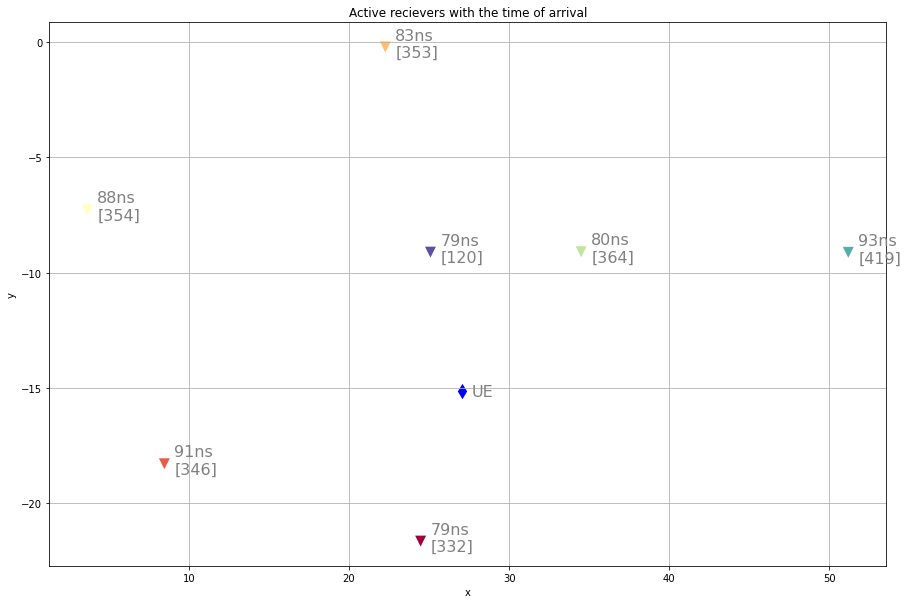

In [51]:
cmap = matplotlib.colormaps['Spectral']
fig, ax = plt.subplots(figsize=(15,10))

ue_data.plot('x', 'y', kind='scatter', ax=ax, s=120, linewidth=0, 
        c='blue', colormap=cmap, marker="d")

df.plot('x', 'y', kind='scatter', ax=ax, s=120, linewidth=0, 
        c=range(len(df)), colormap=cmap, marker="v")

for k, v in ue_data.iterrows():
    ax.annotate("UE", v[['x', 'y']],
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=16, color='grey')

for idx, (k, v) in enumerate(df.iterrows()):
    ax.annotate("{}ns\n[{}]".format(peaks[idx], k), v[['x', 'y']],
                xytext=(10,-10), textcoords='offset points',
                family='sans-serif', fontsize=16, color='grey')
    
plt.title("Active recievers with the time of arrival")
    
ax.grid(True)

### Reading the other .mat file

In [11]:
branch_mat_path = 'dataset/T20230222_1302__RIBM_optimum_branches_rTE.mat'
branches_data_mat = scipy.io.loadmat(branch_mat_path)
branches_data_mat


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Feb 22 13:02:25 2023',
 '__version__': '1.0',
 '__globals__': [],
 'rTE_matrix': array([[  0.        ,   7.74469381,  -4.13546779,   3.11190117,
          -0.18152211,   4.7988535 ,  -2.83226901],
        [ -7.74469381,   0.        , -11.52184098,  -4.64399077,
          -7.62628771,  -2.65376507, -10.41896357],
        [  4.13546779,  11.52184098,   0.        ,  10.27700132,
           4.2453119 ,   9.26767645,   1.82522164],
        [ -3.11190117,   4.64399077, -10.27700132,   0.        ,
          -3.16749687,   1.21939564,  -5.82649163],
        [  0.18152211,   7.62628771,  -4.2453119 ,   3.16749687,
           0.        ,   4.8454585 ,  -2.6961573 ],
        [ -4.7988535 ,   2.65376507,  -9.26767645,  -1.21939564,
          -4.8454585 ,   0.        ,  -7.30974219],
        [  2.83226901,  10.41896357,  -1.82522164,   5.82649163,
           2.6961573 ,   7.30974219,   0.        ]])}

In [12]:
branch_data = pd.DataFrame(branches_data_mat['rTE_matrix'])
branch_data

,0,1,2,3,4,5,6
0,0.000000,7.744694,-4.135468,3.111901,-0.181522,4.798853,-2.832269
1,-7.744694,0.000000,-11.521841,-4.643991,-7.626288,-2.653765,-10.418964
2,4.135468,11.521841,0.000000,10.277001,4.245312,9.267676,1.825222
3,-3.111901,4.643991,-10.277001,0.000000,-3.167497,1.219396,-5.826492
4,0.181522,7.626288,-4.245312,3.167497,0.000000,4.845459,-2.696157
5,-4.798853,2.653765,-9.267676,-1.219396,-4.845459,0.000000,-7.309742
6,2.832269,10.418964,-1.825222,5.826492,2.696157,7.309742,0.000000
